**Créditos**

Esta atividade foi adaptada do *Rivet tutorial for LHC* elaborado por Christian Gütschow (UCL) em agosto de 2024.

# 1. Introdução

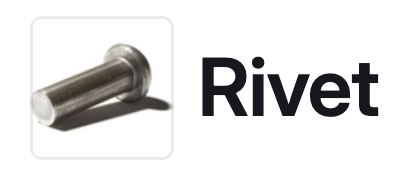


Nesta atividade, vamos usar  o [Rivet](https://gitlab.com/hepcedar/rivet) (*Robust Independent Validation of Experiment and Theory*) para analisar eventos no nível do truth do Monte Carlo (*particle-level events*) usando definições fiduciais (espaço de fase no nível partônico).
No final, você será capaz de editar e executar rotinas de análise simples usando Rivet, além de produzir e plotar histogramas para  ser capaz de escrever suas próprias rotinas.

# 2. Configuração do ambiente

Vamos instalar o Rivet via docker:

`docker pull hepstore/rivet:4.0.1`



Em seguida, execute o container interativamente, dando acesso de leitura/gravação ao seu diretório local usando:

`docker container run -it -v $PWD:$PWD -w $PWD hepstore/rivet:4.0.1 /bin/bash`

Agora precisamos  do *tarball* com os eventos HepMC usados ​​nesta atividade:

`wget "https://rivetval.web.cern.ch/rivetval/TUTORIAL/truth-analysis.tar.gz" -O- | tar -xz --no-same-owner`



# 3. Primeiros passos com o Rivet

Para iniciar uma nova rotina do Rivet, você pode simplesmente usar o script integrado:


```
 rivet-mkanalysis MY_ROUTINE
```



Este script produz um esqueleto de rotina "quase vazio" (um arquivo `.cc`),
e alguns arquivos auxiliares, como um arquivo `.plot` que pode
posteriormente ser usado para configurar o plot  (por exemplo, rótulos de eixo, legenda, etc.) além de um arquivo  `.info` que contém metadados sobre a análise sendo relevante quando se envia uma rotina de análise oficial.

Outra vantagem do Rivet é que  você pode basear a sua rotina em outra já existente. Atualmente, o Rivet vem
com  ${O}(10^3)$ rotinas que documentam a lógica de análise de
medidas de observáveis físicos de partículas para diferentes  colisores, espécies  e energias de feixes. As rotinas existentes podem ser navegadas e inspecionadas usando:


```
  rivet --list-analyses

```

Você deve ter observado uma imensa lista de análises depois desse comando. Agora, vamos refinar um pouco a busca escolhendo um experimento do LHC:

```
  rivet --list-analyses ATLAS_

```

Para refinar ainda mais, podemos escolher uma rotina específica, por exemplo `ATLAS_2019_I1718132`.
```

  rivet --show-analysis ATLAS_2019_I1718132
```

O comando final exibe os metadados encontrados no arquivo
`.info` associado para a rotina `ATLAS_2019_I1718132`.
Como você pode ver, o Rivet sabe muito sobre suas análises
por meio do arquivo `.info` associado!

**Tarefa 1:** navegue pelas várias rotinas e a partir do seu experimento favorito, explore a rotina que escolheu.

Mais adiante nesta atividade, você irá elaborar uma rotina  para produzir o histograma do espectro de massa invariante de um par de léptons provenientes do bóson *Z* (Z->ll\), executada num de nossos arquivos: `Zjets13TeV_10k.hepmc.gz `

Vamos agora explorar uma rotina já existente (ATLAS_2019_I1768911) e executá-la sobre o arquivo: `Zjets13TeV_10k.hepmc.gz `

`rivet -a ATLAS_2019_I1768911 Zjets13TeV_10k.hepmc.gz `

Ao final, você obterá um arquivo  `Rivet.yoda`  (`.yoda` *Yet more Objects for Aata Analysis*). A partir do comando:

`rivet-mkhtml Rivet.yoda`

um diretório `rivet-plots` que contém um arquivo `index.html` entre outros, será criado. Confira!

Para esta atividade vamos usar um rascunho inicial de rotina denominado: `MY_ANALYSIS.cc`, que pode ser visto a seguir:



```
#include "Rivet/Analysis.hh"
#include "Rivet/Projections/FinalState.hh"
#include "Rivet/Projections/FastJets.hh"

namespace Rivet {

  /// @brief Add a short analysis description here
  class MY_ANALYSIS : public Analysis {
  public:

    /// Constructor
    RIVET_DEFAULT_ANALYSIS_CTOR(MY_ANALYSIS);

    /// @name Analysis methods
    /// @{

    /// Book histograms and initialise projections before the run
    void init() {

      _lmode = 0; // default accepts either channel
      if ( getOption("LMODE") == "EL" )  _lmode = 1;
      if ( getOption("LMODE") == "MU" )  _lmode = 2;

      // Book histograms
      vector<double> mll_bins = { 66., 74., 78., 82., 84., 86., 88., 89., 90., 91.,
                                  92., 93., 94., 96., 98., 100., 104., 108., 116. };
      book(_h["mll"], "mass_ll", mll_bins);
      //book(_h["HT"],         "HT",          6,  20., 110.);
      //book(_h["pTmiss"],     "pTmiss",     10,   0., 100.);

      //book(_d["jets_excl"],  "jets_excl",  {0, 1, 2, 3, 4, 5});
      //book(_d["bjets_excl"], "bjets_excl", {0, 1, 2});
    }

    /// Perform the per-event analysis
    void analyze(const Event& event) {

      /// Todo: Reconstruct the dilepton invariant mass to fill the histogram
      // ...
      _h["mll"]->fill(1.0);

    }

    /// Normalise histograms etc., after the run
    void finalize() {

      const double sf = crossSection() / sumOfWeights();
      scale(_h, sf);
      scale(_d, sf);

    }

    /// @}

    /// @name Histograms
    /// @{
    map<string, Histo1DPtr> _h;
    map<string, BinnedHistoPtr<int>> _d;
    size_t _lmode;
    /// @}

  };


  // The hook for the plugin system
  RIVET_DECLARE_PLUGIN(MY_ANALYSIS);
}

```
Observando o esqueleto desta rotina identificamos um layout típico de C++ com alguns arquivos de cabeçalho no topo (*header files*) um método  `init()` que roda uma única vez para inicializar a rotina, um método `analyze(const Event& event)` que é executado para cada evento e um método `finalize()` também executado uma única vez ao final da rotina para realizar algumas tarefas pós-análise (e.g. aplicando fator de escala da seção de choque de produção nos histogramas).

Assim essa rotina  pode ser compilada como qualquer biblioteca C++, e o Rivet fornece um script
que vai adicionar todas as flags de compilador relevantes:

`rivet-build RivetMY_ANALYSIS.so MY_ANALYSIS.cc`

Neste comando, `Rivet*.so` é a forma canônica de um plugin Rivet compilado.




Agora vamos executar a rotina sobre um arquivo HepMC genérico:


`rivet --pwd -a MY_ANALYSIS input.hepmc.gz`

Esse comando usa o script Python  para chamar as bibliotecas Rivet e dizer para executar a rotina `MY_ANALYSIS` sobre o arquivo `input.hepmc.gz`. O primeiro argumento diz ao Rivet para procurar no diretório de trabalho atual. Isso é necessário pois o Rivet não saberia onde procurar
por uma rotina fornecida pelo usuário.

Estes são os primeiros passos para começarmos nossa tarefa de análise.

# 4. Trabalhando com a rotina `MY_ANALYSIS`

Observe no método `init()` como se define o valor da variável membro `_lmode`. O valor padrão de `_lmode`
 é 0, mas também pode ser 1 ou 2, dependendo de como a opção "LMODE"
(abreviação de `lepton mode', mas pode ser qualquer coisa) é definida ao chamar a rotina.
O valor padrão de uma opção é a string vazia (`" "`), a menos que o usuário especifique um valor ao chamar a rotina, por exemplo, assim:


```
rivet -a MY_ANALYSIS:LMODE=EL,MY_ANALYSIS:LMODE=MU input.hepmc.gz
```

que executaria duas instâncias da rotina, uma vez usando a opção `LMODE=EL` e uma vez com `LMODE=MU`. Qualquer valor do tipo `string` é aceitável, a menos que um certo conjunto de valores permitidos seja especificado no arquivo `.info`.


A última parte do método  `init()` é usada para reservar histogramas.
O tipo de ponteiro de histograma contínuo unidimensional é chamado de `Histo1DPtr`.
Visto que uma rotina pode acumular rapidamente muitas dezenas ou até centenas
de histogramas, geralmente é conveniente coletá-los em um mapa
chave-valor, (`key--value map`) por exemplo, `map<string,Histo1DPtr>`. Este é o tipo C++ do objeto `_h` que é declarado próximo do final da rotina.
Para reservar um histograma 1D, basta usar um dos seguintes comandos:



```
  book(_h["name1"], "name1", bin_edges);
  book(_h["name2"], "name2", nBins, min_edge, max_edge);
  book(_h["name3"], "name3", logspace(nBins, min_edge, max_edge));
  book(_h["name4"], 1, 2, 3);

```

O primeiro argumento é a variável pretendida para o histograma reservado.
Neste caso, fornecemos uma chave exclusiva para o mapa que, por sua vez, cria um espaço reservado.
O segundo argumento é o nome do histograma  que será usado ao
escrever o histograma no arquivo. Pode ser o mesmo que a chave do mapa,
mas não precisa ser. Os argumentos restantes são usados para definir as bordas (`bin edges`) - você pode especificar um vetor de bordas  diretamente, ou pode fornecer um número
de bins entre uma borda mínima do bin e uma borda máxima do bin e deixar o Rivet dividir uniformemente por esse intervalo.



A função `analyze(const Event& event)` é executada uma vez por evento.
Tudo o que ela faz é preencher um histograma com o número
`1.0` (o tipo deste argumento deve corresponder ao tipo de eixo especificado
no construtor do histograma), o que não é tão útil. Caberá a você
fazer com que ele faça algo inteligente em nossa atividade, mas vamos primeiro dar uma olhada na
parte final do esqueleto.

No método `finalize()` o  histograma é escalado por um fator
$\sigma/\sum_i w_i$ onde $\sigma$ é a seção de choque do gerador e
$\sum_i w_i$ é a soma dos pesos.
O Rivet tentará extrair a seção de choque do gerador do arquivo HepMC,
mas o valor sempre pode ser fornecido na linha de comando passando
a flag `--cross-section` (ou mais convenientemente `--x`).

O Rivet  controla a soma total dos pesos de eventos da amostra
para que você não precise se preocupar em implementar um contador.


A função `scale` pode ser chamada em um histograma individual
mas também em um vetor inteiro de histogramas ou um mapa com histogramas como valor. E consequentemente, o Rivet também oferece a função `normalize`.

# 5. Trabalhando com ressonâncias

Em nossa atividade vamos reconstruir o bóson  $Z$ a partir dos
eventos $Z$+jatos fornecidos em um dos arquivos HepMC. Em geral,
a reconstrução de observáveis ​​deve ser baseada nas
partículas de estado final no registro de eventos (`event record`). O registro de eventos pode
ser muito complicado, dependendo do processo, e os detalhes da
implementação geralmente dependem do gerador de eventos de Monte Carlo.

A boa notícia é que não há necessidade de navegar pelo registro de eventos
já que o Rivet fornece um mecanismo poderoso para projetar
o resultado de um cálculo baseado no estado final
do registro de eventos: `projection`.


Uma projeção é semelhante a um filtro — você pode especificar requisitos cinemáticos nas partículas que devem ser consideradas no cálculo
e o Rivet usará essa ferramenta  para projetar
a coleção de partículas de estado final que satisfazem essas restrições
do registro do evento.

As projeções são declaradas no método `init()` e
aplicadas no método `analyze()`.


A projeção mais simples é denominada `FinalState` e como o nome sugere
ela fornece acesso a todas as partículas de estado final.
Ela já está habilitada com um arquivo de cabeçalho (`# include "Rivet/Projections/FinalState.hh"`) em nosso esqueleto e
 pode ser declarada no método `init` da seguinte forma:



```
FinalState fs;
declare(fs, "my_first_projection");

```
 e aplicada para cada evento no método `analyze`:



```
const FinalState& p1 = apply<FinalState>(event, "my_first_projection");
const Particles& fs_particles = p1.particlesByPt();

```

A primeira linha pega o argumento `event` e aplica
o `FinalState` a ele. O resultado do cálculo
é salvo como `p1 `usando uma referência `const`
para eficiência computacional.


É possível fazer perguntas sobre o resultado projetado, por exemplo, neste caso nós o estamos  usando  para recuperar um conjunto de todas as partículas de estado final
ordenadas por seu momento transverso (maior para menor), que
retorna um vetor de objetos `Particle`.


A classe `Particle` é a maneira do Rivet  combinar informações de identificação de partículas
(por exemplo, `p.charge()` ou `p.pid()` para o PDG ID)
e FourMomentum (quadri-momento) `p.momentum()` (ou apenas `p.mom()`)
em uma classe.

Quantidades cinemáticas  são diretamente acessíveis por meio de métodos padrão como: pT, eta, rapidity, E, phi,   abseta,  absrap entre outros.

O Rivet tem um grande conjunto de projeções diferentes disponíveis,
como o `VisibleFinalState` ,
o `PromptFinalState` (todas as partículas de estado final que
não se originaram de um decaimento de hádrons)
ou o `VetoedFinalState `(qualquer coisa, exceto certos tipos de
partículas), só para citar algumas possibilidades.


As projeções usam C++11, criando uma lógica de argumento muito útil:


```
  FinalState charged_tracks(Cuts::charge != 0);
  FinalState IDtrack(Cuts::charge != 0 && Cuts::abseta < 2.5);
  FinalState allMuons(Cuts::abspid == PID::MUON && Cuts::pT > 20*GeV);
  PromptFinalState promptMuons(allMuons);

```


Observe que a primeira linha é apenas uma maneira alternativa de especificar `ChargedFinalState`. A segunda linha pede a mesma coisa, mas com um
requisito adicional sobre a pseudorapidez da partícula carregada.
A terceira linha é uma maneira concisa de pedir todos os múons com um
momento transverso de pelo menos 20 GeV, e a última linha
usa o resultado anterior para obter o subconjunto de múons que não se originam de um decaimento de hádrons.
Imagine ter que escrever tudo isso usando laços de `for` (`for loop`).


**Tarefa 2:**: Modifique o arquivo `.cc`   para selecionar eventos com exatamente um par de léptons de carga oposta,
de mesmo sabor, usando léptons com um momento transverso de pelo menos 10 GeV
e restrito a ficar dentro de 2,5 em pseudorapidez.
Certifique-se de selecionar um par de elétrons ou múons dependendo do valor de `_lmode`.
Use os pares de léptons selecionados para reconstruir a massa invariante do dilépton e passe-a para o histograma preparado. Compile a rotina e execute-a sobre os eventos HepMC fornecidos usando ambas as opções de sabor de lépton na mesma execução. (Dica: abra o arquivo `.cc` da análise [ATLAS_2019_I1718132](https://gitlab.com/hepcedar/rivet/-/blob/release-4-0-x/analyses/pluginATLAS/ATLAS_2019_I1718132.cc?ref_type=heads) ).